<a href="https://colab.research.google.com/github/Jordan-Jonathan/MAE-UCI-HAR/blob/main/MAE_UCI_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# --- 1. FIND THE DATASET ---
# This loop finds where 'body_acc_x_train.txt' is hiding
data_root = None
print("Searching for dataset...")
for root, dirs, files in os.walk("/content"): # Scans Drive and Local
    if "body_acc_x_train.txt" in files:
        data_root = root # This is the .../train/Inertial Signals/ folder
        print(f"Found train data at: {data_root}")
        break

if data_root is None:
    raise FileNotFoundError("Could not locate the dataset! Make sure you ran the Download or Drive Mount cell first.")

# --- 2. DEFINE LOADING FUNCTION ---
def load_raw_signals(group='train'):
    filenames = [
        f'body_acc_x_{group}.txt', f'body_acc_y_{group}.txt', f'body_acc_z_{group}.txt',
        f'body_gyro_x_{group}.txt', f'body_gyro_y_{group}.txt', f'body_gyro_z_{group}.txt',
        f'total_acc_x_{group}.txt', f'total_acc_y_{group}.txt', f'total_acc_z_{group}.txt'
    ]

    loaded_signals = []

    # Adjust path based on whether we need 'train' or 'test'
    # data_root is 'train', so we go up two levels to find 'test'
    dataset_base = os.path.dirname(os.path.dirname(data_root))
    target_path = os.path.join(dataset_base, group, "Inertial Signals")

    print(f"Loading {group} data from {target_path}...")

    for name in filenames:
        file_path = os.path.join(target_path, name)
        if not os.path.exists(file_path):
             print(f"Error: File not found {file_path}")
             continue

        # Use raw string for sep to avoid warning
        df = pd.read_csv(file_path, sep=r'\s+', header=None)
        loaded_signals.append(df.values)

    return np.dstack(loaded_signals)

# --- 3. LOAD DATA ---
X_train_raw = load_raw_signals('train')
X_test_raw = load_raw_signals('test')

print(f"Original Train Shape: {X_train_raw.shape}")

# --- 4. APPLY Z-NORMALIZATION ---
print("Applying Sensor-wise Z-Normalization...")

scaler = StandardScaler()

# Flatten to (Total_Samples, 9) because Scaler expects 2D data
N_train, T, C = X_train_raw.shape
N_test = X_test_raw.shape[0]

X_train_flat = X_train_raw.reshape(-1, C)
X_test_flat = X_test_raw.reshape(-1, C)

# Fit on TRAIN, Transform on BOTH
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshape back to (Samples, 128, 9)
X_train_raw = X_train_scaled.reshape(N_train, T, C)
X_test_raw = X_test_scaled.reshape(N_test, T, C)

print("Success! Data is now Normalized (Mean=0, Std=1).")
print(f"Final Training Data Shape: {X_train_raw.shape}")

Searching for dataset...
Found train data at: /content/drive/MyDrive/ETS Machine Learning/UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals
Loading train data from /content/drive/MyDrive/ETS Machine Learning/UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals...
Loading test data from /content/drive/MyDrive/ETS Machine Learning/UCI HAR Dataset/UCI HAR Dataset/test/Inertial Signals...
Original Train Shape: (7352, 128, 9)
Applying Sensor-wise Z-Normalization...
Success! Data is now Normalized (Mean=0, Std=1).
Final Training Data Shape: (7352, 128, 9)


In [46]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MAE_HAR(nn.Module):
    def __init__(self, seq_len=128, in_channels=9, embed_dim=64, mask_ratio=0.75):
        super().__init__()
        self.seq_len = seq_len
        self.patch_size = 4  # Break 128 steps into chunks of 4
        self.num_patches = seq_len // self.patch_size
        self.embed_dim = embed_dim
        self.mask_ratio = mask_ratio

        # 1. Patch Embedding (Linear Projection)
        self.encoder_projection = nn.Linear(in_channels * self.patch_size, embed_dim)

        # 2. Encoder (The "Brain")
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=128, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # 3. Decoder (The "Reconstructor")
        self.decoder_projection = nn.Linear(embed_dim, embed_dim)
        decoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=128, batch_first=True)
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=1)

        # 4. Output Head
        self.output_head = nn.Linear(embed_dim, in_channels * self.patch_size)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        # Reshape [Batch, 128, 9] -> [Batch, 32, 36]
        x_patches = x.view(batch_size, self.num_patches, -1)
        embeddings = self.encoder_projection(x_patches) + self.pos_embedding

        # --- MASKING PROCESS ---
        num_masked = int(self.mask_ratio * self.num_patches)
        num_keep = self.num_patches - num_masked
        noise = torch.rand(batch_size, self.num_patches, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :num_keep]

        # Keep visible patches
        x_masked = torch.gather(embeddings, 1, ids_keep.unsqueeze(-1).repeat(1, 1, self.embed_dim))

        # Encode
        latent = self.encoder(x_masked)

        # Append Mask Tokens (Placeholders)
        mask_tokens = self.mask_token.repeat(batch_size, num_masked, 1)
        x_full = torch.cat([latent, mask_tokens], dim=1)
        x_full = torch.gather(x_full, 1, ids_restore.unsqueeze(-1).repeat(1, 1, self.embed_dim))

        # Decode
        decoded = self.decoder(self.decoder_projection(x_full))
        reconstruction = self.output_head(decoded)

        # Reshape back to original signal format
        return reconstruction.view(batch_size, self.seq_len, -1)

Using device: cpu


In [47]:
# Convert numpy data to PyTorch Tensors
tensor_x = torch.Tensor(X_train_raw) # Transform to torch tensor
dataset = TensorDataset(tensor_x)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize Model
model = MAE_HAR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() # Mean Squared Error Loss

print("Starting MAE Training...")
loss_history = []

for epoch in range(20): # Train for 20 epochs
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)

        # Forward pass
        reconstruction = model(inputs)

        # Compute loss (Compare Original vs Reconstructed)
        loss = criterion(reconstruction, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/20], Reconstruction Loss: {avg_loss:.5f}")

print("Training Complete!")

Starting MAE Training...
Epoch [1/20], Reconstruction Loss: 0.69155
Epoch [2/20], Reconstruction Loss: 0.56861
Epoch [3/20], Reconstruction Loss: 0.55055
Epoch [4/20], Reconstruction Loss: 0.54213
Epoch [5/20], Reconstruction Loss: 0.53619
Epoch [6/20], Reconstruction Loss: 0.53217
Epoch [7/20], Reconstruction Loss: 0.52951
Epoch [8/20], Reconstruction Loss: 0.52845
Epoch [9/20], Reconstruction Loss: 0.52655
Epoch [10/20], Reconstruction Loss: 0.52358
Epoch [11/20], Reconstruction Loss: 0.52348
Epoch [12/20], Reconstruction Loss: 0.52182
Epoch [13/20], Reconstruction Loss: 0.52239
Epoch [14/20], Reconstruction Loss: 0.51986
Epoch [15/20], Reconstruction Loss: 0.51910
Epoch [16/20], Reconstruction Loss: 0.51922
Epoch [17/20], Reconstruction Loss: 0.51834
Epoch [18/20], Reconstruction Loss: 0.51951
Epoch [19/20], Reconstruction Loss: 0.51764
Epoch [20/20], Reconstruction Loss: 0.51783
Training Complete!


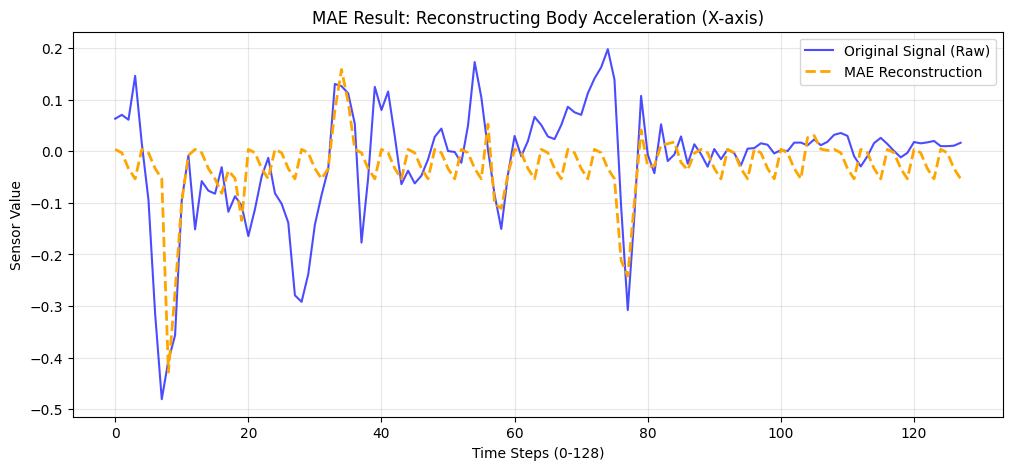

In [51]:
import matplotlib.pyplot as plt

# Get one sample from the test set
model.eval()
test_sample = torch.Tensor(X_test_raw[0:1]).to(device) # Take 1st sample

with torch.no_grad():
    reconstructed_sample = model(test_sample)

# Move back to CPU for plotting
original = test_sample.cpu().numpy()[0]
reconstructed = reconstructed_sample.cpu().numpy()[0]

# Plotting
plt.figure(figsize=(12, 5))

# Plot Body Acceleration X-Axis (Column 0)
plt.plot(original[:, 0], label='Original Signal (Raw)', color='blue', alpha=0.7)
plt.plot(reconstructed[:, 0], label='MAE Reconstruction', color='orange', linestyle='--', linewidth=2)

plt.title("MAE Result: Reconstructing Body Acceleration (X-axis)")
plt.xlabel("Time Steps (0-128)")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
import torch.nn.functional as F
import pandas as pd # Ensure pandas is imported if not already in this cell
import os

# 1. LOAD LABELS (y_train and y_test)
def load_labels(group='train'):
    filename = f'y_{group}.txt'
    # Search for the file in the folder structure
    for root, dirs, files in os.walk("."):
        if filename in files:
            path = os.path.join(root, filename)
            # Use raw string r'\s+' to fix SyntaxWarning
            return pd.read_csv(path, sep=r'\s+', header=None).values.flatten() - 1
    print(f"Error: Could not find {filename}")
    return None

y_train = load_labels('train')
y_test = load_labels('test')

# Convert to Tensors
tensor_y_train = torch.LongTensor(y_train).to(device)
tensor_y_test = torch.LongTensor(y_test).to(device)
tensor_x_train = torch.Tensor(X_train_raw).to(device)
tensor_x_test = torch.Tensor(X_test_raw).to(device)

# 2. DEFINE THE CLASSIFIER MODEL (Fine-Tuning)
class MAE_Classifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes=6):
        super().__init__()
        # Take ONLY the Encoder from the pre-trained MAE
        self.encoder = pretrained_mae.encoder
        self.encoder_proj = pretrained_mae.encoder_projection
        self.pos_embed = pretrained_mae.pos_embedding
        self.patch_size = pretrained_mae.patch_size
        self.num_patches = pretrained_mae.num_patches

        # Add a new Classification Head
        self.classifier_head = nn.Linear(64 * self.num_patches, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        # FIXED: Use .reshape() instead of .view() to handle non-contiguous memory
        x_patches = x.reshape(batch_size, self.num_patches, -1)
        embeddings = self.encoder_proj(x_patches) + self.pos_embed

        # Pass through the Pre-Trained "Brain" (Encoder)
        features = self.encoder(embeddings)

        # Flatten features and classify
        features_flat = features.reshape(batch_size, -1) # Changed to reshape here too just in case
        logits = self.classifier_head(features_flat)
        return logits

# 3. TRAIN THE CLASSIFIER
# Create the classifier using your existing 'model' from previous steps
classifier = MAE_Classifier(model).to(device)
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion_cls = nn.CrossEntropyLoss()

print("Fine-tuning MAE for Classification...")
dataset_cls = TensorDataset(tensor_x_train, tensor_y_train)
dataloader_cls = DataLoader(dataset_cls, batch_size=64, shuffle=True)

for epoch in range(15): # Train for 15 epochs
    classifier.train()
    correct = 0
    total = 0

    for inputs, labels in dataloader_cls:
        optimizer_cls.zero_grad()
        outputs = classifier(inputs)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_cls.step()

        # Calculate Training Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}: Accuracy = {100 * correct / total:.2f}%")

# 4. FINAL TEST ACCURACY
classifier.eval()
with torch.no_grad():
    outputs = classifier(tensor_x_test)
    _, predicted = torch.max(outputs.data, 1)
    total = tensor_y_test.size(0)
    correct = (predicted == tensor_y_test).sum().item()

final_acc = 100 * correct / total
print(f"\n--------------------------------")
print(f"FINAL MAE CLASSIFICATION ACCURACY: {final_acc:.2f}%")
print(f"--------------------------------")

Fine-tuning MAE for Classification...
Epoch 1: Accuracy = 86.19%
Epoch 2: Accuracy = 94.53%
Epoch 3: Accuracy = 94.80%
Epoch 4: Accuracy = 94.68%
Epoch 5: Accuracy = 95.16%
Epoch 6: Accuracy = 95.29%
Epoch 7: Accuracy = 95.06%
Epoch 8: Accuracy = 95.23%
Epoch 9: Accuracy = 95.70%
Epoch 10: Accuracy = 95.73%
Epoch 11: Accuracy = 94.95%
Epoch 12: Accuracy = 95.61%
Epoch 13: Accuracy = 95.80%
Epoch 14: Accuracy = 96.21%
Epoch 15: Accuracy = 96.60%

--------------------------------
FINAL MAE CLASSIFICATION ACCURACY: 93.25%
--------------------------------
